In [1]:
from catboost import CatBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
import numpy as np
import pandas as pd
import types
from collections import defaultdict
import itertools
from dataclasses import dataclass, field

In [2]:
with open("words_250000_train.txt", "r") as f:
    words: list[str] = [w.strip() for w in f.readlines()]




In [3]:
@dataclass
class State:
    already_guessed: set[str] = field(default_factory=set)
    def clear(self):
        self.already_guessed.clear()




In [4]:
print(ord('a'))
print(ord('z'))

97
122


In [5]:
def guess(self, word: str) -> str:
    letter_indices = list(range(97, 123))
    for letter_idx in letter_indices:
        if letter_idx not in self.already_guessed:
            self.already_guessed.append(letter_idx)
            return chr(letter_idx)




In [6]:
def play_game(actual_word, guess_fn) -> int:
    max_mistakes = 7
    current_word = "".join(["_"] * len(actual_word))
    mistakes = 0
    while mistakes < max_mistakes:
        guesssed_word = guess_fn(current_word)
        if not guesssed_word.isalpha() or len(guesssed_word) != 1:
            raise ValueError("Guess must be a single letter")
        if guesssed_word in actual_word:
            new_word = list(current_word)
            for i, c in enumerate(actual_word):
                if c == guesssed_word:
                    new_word[i] = guesssed_word
            current_word = "".join(new_word)
            if current_word == actual_word:
                return 1
        else:
            mistakes += 1
    return 0

In [7]:
state = State()
state.guess = types.MethodType(guess, state)
play_game("bhijkccnbr", lambda x: state.guess(x))

AttributeError: 'set' object has no attribute 'append'

In [12]:
char_freq: defaultdict[str, int] = defaultdict(int)
for word in words:
    for l in word:
        char_freq[l] += 1

char_freq = [item[1] for item in sorted(char_freq.items(), key=lambda item: item[0], )]
char_freq



[179837,
 39840,
 89367,
 74856,
 233745,
 26431,
 51850,
 58051,
 184746,
 3790,
 18685,
 122431,
 62191,
 152259,
 150052,
 65785,
 3986,
 149228,
 148462,
 137277,
 77304,
 21057,
 17732,
 6050,
 40985,
 8749]

In [67]:
def guess(self, word: str) -> str:
    letter_indices = list(range(97, 123))
    for letter_idx in letter_indices:
        if letter_idx not in self.already_guessed:
            self.already_guessed.add(letter_idx)
            return chr(letter_idx)

state = State()
state.guess = types.MethodType(guess, state)

game_results = []
for word in words:
    game_result = play_game(word, lambda x: state.guess(x))
    game_results.append(game_result)
    state.clear()



print("mean score:", np.mean(game_results))

mean score: 0.006291245050593928


In [64]:
freq_descending_list = list(char_freq.keys())
def guess(self, word: str) -> str:
    letter_indices = list(range(97, 123))
    for letter in freq_descending_list:
        if letter not in self.already_guessed:
            self.already_guessed.add(letter)
            return letter



state = State()
state.guess = types.MethodType(guess, state)

game_results = []
for word in words:
    game_result = play_game(word, lambda x: state.guess(x))
    game_results.append(game_result)
    state.clear()



In [ ]:
print("mean score:", np.mean(game_results))

mean score: 0.2074483062032556


In [71]:

word_lens = [len(word) for word in words]
print(np.percentile(word_lens, 99))


17.0


In [79]:
max_revealed_chars = 17
def gen_x_y_for_word(word: str) -> tuple[np.array, np.array]:
    """
    returns a (combinations - 1) X 34 array, and a 
    (combinations - 1) X 26 array of labels
    """
    set_chars = set(word)
    x = []
    y = []
    for comb_len in range(1, min(len(set_chars), max_revealed_chars) ):
        for combination in itertools.combinations(set_chars, comb_len):
            x_row = [0] * 34
            y_row = [0] * 26
            x.append(x_row)
            y.append(y_row)
    return np.array(x), np.array(y)




In [85]:
class PositionalEncoder():
    """ An implementation of positional encoding.

    Attributes:
        d_model (int): The number of embedding dimensions in the learned
            embeddings. This is used to determine the length of the positional
            encoding vectors, which make up the rows of the positional encoding
            matrix.
        max_length (int): The maximum sequence length in the transformer. This
            is used to determine the size of the positional encoding matrix.
        rounding (int): The number of decimal places to round each of the
            values to in the output positional encoding matrix.
    """

    def __init__(self, d_model, max_length, rounding):
        self.d_model = d_model
        self.max_length = max_length
        self.rounding = rounding

    def generate_positional_encoding(self):
        """ Generate positional information to add to inputs for encoding.

        The positional information is generated using the number of embedding
        dimensions (d_model), the maximum length of the sequence (max_length),
        and the number of decimal places to round to (rounding). The output
        matrix generated is of size (max_length X embedding_dim), where each
        row is the positional information to be added to the learned
        embeddings, and each column is an embedding dimension.
        """

        position = np.arange(0, self.max_length).reshape(self.max_length, 1)
        even_i = np.arange(0, self.d_model, 2)
        denominator = 10_000**(even_i / self.d_model)

        even_encoded = np.round(np.sin(position / denominator), self.rounding)
        odd_encoded = np.round(np.sin(position / denominator), self.rounding)

        # Interleave the even and odd encodings
        positional_encoding = np.stack((even_encoded, odd_encoded),2).reshape(even_encoded.shape[0],-1)

        # If self.d_model is odd remove the extra column generated
        if self.d_model % 2 == 1:
            positional_encoding = np.delete(positional_encoding, -1, axis=1)

        return positional_encoding

    def encode(self, input):
        """ Encode the input by adding positional information.

        Args:
            input (np.array): A two-dimensional array of embeddings. The array
                should be of size (self.max_length x self.d_model).

        Returns:
            output (np.array): A two-dimensional array of embeddings plus the
                positional information. The array has size (self.max_length x
                self.d_model).
        """
        positional_encoding = self.generate_positional_encoding()
        output = input + positional_encoding

        return output

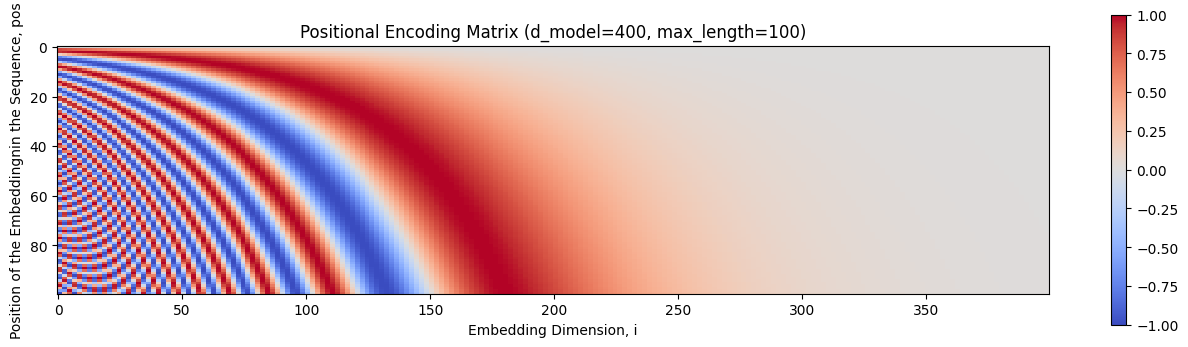

In [86]:
import matplotlib.pyplot as plt

# Instantiate a PositionalEncoder class
d_model = 400
max_length = 100
rounding = 4

PE = PositionalEncoder(d_model=d_model,
                       max_length=max_length,
                       rounding=rounding)

# Generate positional encodings
input = np.round(np.random.rand(max_length, d_model), 4)
positional_encoding = PE.generate_positional_encoding()

# Plot positional encodings
cax = plt.matshow(positional_encoding, cmap='coolwarm')
plt.title(f'Positional Encoding Matrix ({d_model=}, {max_length=})')
plt.ylabel('Position of the Embeddingnin the Sequence, pos')
plt.xlabel('Embedding Dimension, i')
plt.gcf().colorbar(cax)
plt.gca().xaxis.set_ticks_position('bottom')

In [84]:
positional_encoding

array([[ 0.000e+00,  1.000e+00,  0.000e+00, ...,  1.000e+00,  0.000e+00,
         1.000e+00],
       [ 8.415e-01,  5.403e-01,  8.163e-01, ...,  1.000e+00,  1.000e-04,
         1.000e+00],
       [ 9.093e-01, -4.161e-01,  9.430e-01, ...,  1.000e+00,  2.000e-04,
         1.000e+00],
       ...,
       [ 3.796e-01, -9.251e-01, -9.991e-01, ...,  9.999e-01,  1.020e-02,
         9.999e-01],
       [-5.734e-01, -8.193e-01, -6.119e-01, ...,  9.999e-01,  1.030e-02,
         9.999e-01],
       [-9.992e-01,  3.980e-02,  2.922e-01, ...,  9.999e-01,  1.040e-02,
         9.999e-01]])

In [87]:
a = np.array([3])

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set random seed for reproducibility
torch.manual_seed(42)

# Example 1: Basic MultiheadAttention usage
print("=== Basic MultiheadAttention Example ===")

# Parameters
batch_size = 2
seq_len = 10
embed_dim = 512
num_heads = 8

# Create the MultiheadAttention layer
multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)

# Create sample input tensors
# Shape: (seq_len, batch_size, embed_dim)
query = torch.randn(seq_len, batch_size, embed_dim)
key = torch.randn(seq_len, batch_size, embed_dim)
value = torch.randn(seq_len, batch_size, embed_dim)

print(f"Input shapes:")
print(f"Query: {query.shape}")
print(f"Key: {key.shape}")
print(f"Value: {value.shape}")

# Forward pass
attn_output, attn_weights = multihead_attn(query, key, value)

print(f"\nOutput shapes:")
print(f"Attention output: {attn_output.shape}")
print(f"Attention weights: {attn_weights.shape}")

# Example 2: Self-attention (query, key, value are the same)
print("\n=== Self-Attention Example ===")

# For self-attention, use the same tensor for query, key, and value
input_seq = torch.randn(seq_len, batch_size, embed_dim)
self_attn_output, self_attn_weights = multihead_attn(input_seq, input_seq, input_seq)

print(f"Self-attention output shape: {self_attn_output.shape}")
print(f"Self-attention weights shape: {self_attn_weights.shape}")

# Example 3: Cross-attention with different sequence lengths
print("\n=== Cross-Attention Example ===")

# Different sequence lengths for encoder-decoder attention
encoder_seq_len = 15
decoder_seq_len = 8

# Create cross-attention layer
cross_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)

# Decoder queries, encoder keys and values
decoder_query = torch.randn(decoder_seq_len, batch_size, embed_dim)
encoder_kv = torch.randn(encoder_seq_len, batch_size, embed_dim)

cross_attn_output, cross_attn_weights = cross_attn(
    query=decoder_query,
    key=encoder_kv,
    value=encoder_kv
)

print(f"Cross-attention output shape: {cross_attn_output.shape}")
print(f"Cross-attention weights shape: {cross_attn_weights.shape}")

# Example 4: Using attention masks
print("\n=== Attention with Masking Example ===")

# Create a causal mask for decoder self-attention (prevents looking at future tokens)
def generate_square_subsequent_mask(sz):
    """Generate a square mask for the sequence. The masked positions are filled with float('-inf')."""
    mask = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
    return mask

causal_mask = generate_square_subsequent_mask(seq_len)
print(f"Causal mask shape: {causal_mask.shape}")

# Apply masked self-attention
masked_attn_output, masked_attn_weights = multihead_attn(
    query=input_seq,
    key=input_seq,
    value=input_seq,
    attn_mask=causal_mask
)

print(f"Masked attention output shape: {masked_attn_output.shape}")

# Example 5: Key padding mask (for variable length sequences)
print("\n=== Key Padding Mask Example ===")

# Create a key padding mask (True for positions to ignore)
# Let's say batch has sequences of different lengths: [8, 6] out of max 10
key_padding_mask = torch.tensor([
    [False, False, False, False, False, False, False, False, True, True],  # First sample: length 8
    [False, False, False, False, False, False, True, True, True, True]     # Second sample: length 6
])

padded_attn_output, padded_attn_weights = multihead_attn(
    query=input_seq,
    key=input_seq,
    value=input_seq,
    key_padding_mask=key_padding_mask
)

print(f"Padded attention output shape: {padded_attn_output.shape}")

# Example 6: Complete Transformer block with MultiheadAttention
print("\n=== Transformer Block Example ===")

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None, key_padding_mask=None):
        # Self-attention with residual connection
        attn_out, _ = self.attention(x, x, x, attn_mask=mask, key_padding_mask=key_padding_mask)
        x = self.norm1(x + self.dropout(attn_out))
        
        # Feed-forward with residual connection
        ff_out = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_out))
        
        return x

# Create and test the transformer block
transformer_block = TransformerBlock(embed_dim=embed_dim, num_heads=num_heads, ff_dim=2048)
transformer_output = transformer_block(input_seq)

print(f"Transformer block output shape: {transformer_output.shape}")

# Example 7: Batch-first format (more common in practice)
print("\n=== Batch-First Format Example ===")

# Create MultiheadAttention with batch_first=True
batch_first_attn = nn.MultiheadAttention(
    embed_dim=embed_dim, 
    num_heads=num_heads, 
    batch_first=True
)

# Input shape: (batch_size, seq_len, embed_dim)
batch_first_input = torch.randn(batch_size, seq_len, embed_dim)
bf_output, bf_weights = batch_first_attn(
    batch_first_input, 
    batch_first_input, 
    batch_first_input
)

print(f"Batch-first input shape: {batch_first_input.shape}")
print(f"Batch-first output shape: {bf_output.shape}")
print(f"Batch-first weights shape: {bf_weights.shape}")

print("\n=== Summary ===")
print("Key points about PyTorch MultiheadAttention:")
print("1. Default input format: (seq_len, batch_size, embed_dim)")
print("2. Use batch_first=True for (batch_size, seq_len, embed_dim)")
print("3. Returns (attention_output, attention_weights)")
print("4. Supports various masking strategies")
print("5. Can be used for self-attention and cross-attention")

=== Basic MultiheadAttention Example ===
Input shapes:
Query: torch.Size([10, 2, 512])
Key: torch.Size([10, 2, 512])
Value: torch.Size([10, 2, 512])

Output shapes:
Attention output: torch.Size([10, 2, 512])
Attention weights: torch.Size([2, 10, 10])

=== Self-Attention Example ===
Self-attention output shape: torch.Size([10, 2, 512])
Self-attention weights shape: torch.Size([2, 10, 10])

=== Cross-Attention Example ===
Cross-attention output shape: torch.Size([8, 2, 512])
Cross-attention weights shape: torch.Size([2, 8, 15])

=== Attention with Masking Example ===
Causal mask shape: torch.Size([10, 10])
Masked attention output shape: torch.Size([10, 2, 512])

=== Key Padding Mask Example ===
Padded attention output shape: torch.Size([10, 2, 512])

=== Transformer Block Example ===
Transformer block output shape: torch.Size([10, 2, 512])

=== Batch-First Format Example ===
Batch-first input shape: torch.Size([2, 10, 512])
Batch-first output shape: torch.Size([2, 10, 512])
Batch-first w

In [17]:
sz = 4
torch.tril(torch.ones(sz, sz) * float('-inf'), )

tensor([[-inf, 0., 0., 0.],
        [-inf, -inf, 0., 0.],
        [-inf, -inf, -inf, 0.],
        [-inf, -inf, -inf, -inf]])